In [8]:
from keras.preprocessing.image import array_to_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D
from keras import backend as K

from IPython.display import display_png
from PIL import Image, ImageOps

import numpy as np

In [9]:
#저해상도 이미지 생성
def drop_resolution(x, scale=3.0):
    size = (x.shape[0], x.shape[1])
    small_size = (int(size[0]/scale), int(size[1]/scale))
    img = array_to_img(x)
    small_img = img.resize(small_size, resample=3)
    
    return img_to_array(small_img.resize(img.size, resample=3))

In [10]:
#입력 데이터 생성

def data_generator(data_dir, mode, scale=2.0, target_size=(200,200), batch_size=32, shuffle=True):
    for imgs in ImageDataGenerator().flow_from_directory(
    directory=data_dir,
    classes=[mode],
    class_mode=None,
    color_mode='rgb',
    target_size=target_size,
    shuffle=shuffle):
        x = np.array([drop_resolution(img,scale) for img in imgs])
        yield x/255., imgs/255.

In [11]:
DATA_DIR = 'test_img/'
N_TRAIN_DATA = 10
N_TEST_DATA = 1
BATCH_SIZE = 2

train_data_generator = data_generator(DATA_DIR, 'train', batch_size=BATCH_SIZE)

test_x, test_y = next(data_generator(DATA_DIR, 'test', batch_size=N_TEST_DATA,shuffle=False))

Found 1 images belonging to 1 classes.


In [12]:
#모델 구축

model = Sequential()

model.add(Conv2D(filters=64,
                kernel_size=9,
                padding='same',
                activation='relu',
                input_shape=(None, None, 3)))
model.add(Conv2D(filters=32,
                kernel_size=1,
                padding='same',
                activation='relu'))
model.add(Conv2D(filters=3,
                kernel_size=5,
                padding='same'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, None, None, 64)    15616     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, None, None, 32)    2080      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, None, None, 3)     2403      
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [13]:
#SRCNN에서는 평가는 PSNR(Peek Signal-to-Noise Ratio)을 이용

def psnr(y_true, y_pred):
    return -10*K.log(K.mean(K.flatten((y_true-y_pred))**2))/np.log(10)

model.compile(loss='mean_squared_error',
             optimizer='adam',
             metrics=[psnr])
model.fit_generator(train_data_generator,
                   validation_data=(test_x,test_y),
                   steps_per_epoch=N_TRAIN_DATA//BATCH_SIZE,
                   epochs=50)
pred = model.predict(test_x)

Epoch 1/50
Found 10 images belonging to 1 classes.
5/5 [==============================] - 8s 2s/step - loss: 0.2654 - psnr: 7.1095 - val_loss: 0.1148 - val_psnr: 9.3999
Epoch 2/50
5/5 [==============================] - 7s 1s/step - loss: 0.0637 - psnr: 12.0985 - val_loss: 0.0841 - val_psnr: 10.7500
Epoch 3/50
5/5 [==============================] - 7s 1s/step - loss: 0.0403 - psnr: 14.3927 - val_loss: 0.0334 - val_psnr: 14.7613
Epoch 4/50
5/5 [==============================] - 7s 1s/step - loss: 0.0304 - psnr: 15.1984 - val_loss: 0.0236 - val_psnr: 16.2668
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 0.0242 - psnr: 16.1692 - val_loss: 0.0176 - val_psnr: 17.5369
Epoch 6/50
5/5 [==============================] - 7s 1s/step - loss: 0.0196 - psnr: 17.0859 - val_loss: 0.0205 - val_psnr: 16.8795
Epoch 7/50
5/5 [==============================] - 7s 1s/step - loss: 0.0173 - psnr: 17.6257 - val_loss: 0.0163 - val_psnr: 17.8727
Epoch 8/50
5/5 [=============================

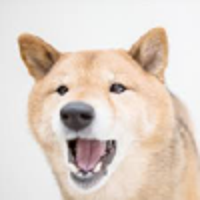

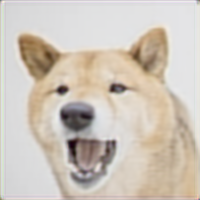

In [14]:
pred_img = pred[0]
pred_img = array_to_img(pred_img)

test_img = array_to_img(test_x[0])


display_png(test_img)
display_png(pred_img)